# Functions Development

In [ ]:
# Import Libraries and Setup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set up display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

## Function 1: Get Stock Data and Explore
def get_stocks_data(symbols, start_date, end_date):
    """
    Get data for multiple stocks, however it rest of the code relies on a single stock's data structure.
    More testing & development to come for multi-stock support.
    """
    if isinstance(symbols, str):
        symbols = [symbols]  # Convert single string to list
    
    print(f"Getting data for {symbols} from {start_date} to {end_date}...")
    data = yf.download(symbols, start=start_date, end=end_date)
    print(f"Got {len(data)} days of data for {len(symbols)} stocks")
    
    # Flatten if only one stock to keep it simple
    if len(symbols) == 1:
        data = data.droplevel(1, axis=1)
    
    return data
    
## Function 2: Define and Test Dip Buying Strategy
def dip_buying_strategy(data, daily_budget=10, dip_threshold=0.10):
    """
    Buy when stock drops by dip_threshold (default 10%) from recent peak
    Money accumulates daily until a dip occurs
    """
    cash = 0
    shares = 0
    transactions = []
    daily_values = pd.Series(dtype=float)

    # Track the highest price seen so far (rolling peak)
    peak_price = data['Close'].iloc[0]
    
    print(f"Running Dip Buying Strategy:")
    print(f"- Daily budget: ${daily_budget}")
    print(f"- Dip threshold: {dip_threshold*100}%")
    print(f"- Starting peak price: ${peak_price:.2f}")
    print()
    
    for i, (date, row) in enumerate(data.iterrows()):
        current_price = row['Close']
        cash += daily_budget  # Add daily budget
        
        # Update peak price if current price is higher
        if current_price > peak_price:
            peak_price = current_price
        
        # Check if current price is below the dip threshold
        dip_price = peak_price * (1 - dip_threshold)
        
        if current_price <= dip_price and cash >= current_price:
            # Buy as many shares as possible with accumulated cash
            shares_to_buy = int(cash / current_price)
            # Remove this redundant check: if shares_to_buy > 0:
            
            cost = shares_to_buy * current_price
            cash -= cost
            shares += shares_to_buy
            
            dip_percent = ((peak_price - current_price) / peak_price) * 100
            
            transactions.append({
                'Date': date,
                'Price': current_price,
                'Shares': shares_to_buy,
                'Cost': cost,
                'Peak': peak_price,
                'Dip_Percent': dip_percent
            })
            
            # print(f"{date.strftime('%Y-%m-%d')}: Bought {shares_to_buy} shares at ${current_price:.2f}")
            # print(f"   -> {dip_percent:.1f}% dip from peak of ${peak_price:.2f}")
            # print(f"   -> Spent ${cost:.2f}, Cash remaining: ${cash:.2f}")
            # print()
            peak_price = current_price

        # Calculate total portfolio value
        portfolio_value = cash + (shares * current_price)
        daily_values.at[date] = portfolio_value

    total_invested = len(data) * daily_budget
    final_value = cash + (shares * data['Close'].iloc[-1])
    
    return {
        'daily_values': daily_values,
        'transactions': transactions,
        'final_value': final_value,
        'total_invested': total_invested,
        'cash_remaining': cash,
        'shares': shares
    }

## Plotting Function
def plot_stock_data(data, ticker, years = 1):
    """
    Plot the closing price of the stock data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], linewidth=2)
    plt.title(f'{ticker} Stock Price Over Last {years} Year{"s" if years > 1 else ""}')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.show()

## Function 3: Dollar Cost averaging Strategy (weekly)
def dollar_cost_averaging_strategy(data, daily_budget=10, buy_frequency=7):
    """
    Buy every week (every 7 days) with accumulated money
    """
    cash = 0
    shares = 0
    transactions = []
    daily_values = pd.Series(dtype=float)

    print(f"Running Weekly Dollar cost averaging Strategy:")
    print(f"- Daily budget: ${daily_budget}")
    print(f"- Buying frequency: every {buy_frequency} days")
    print()

    for i, (date, row) in enumerate(data.iterrows()):
        current_price = row['Close']
        cash += daily_budget
        if i % buy_frequency == 0 and cash >= current_price:
            shares_to_buy = int(cash / current_price)
            cost = shares_to_buy * current_price
            cash -= cost
            shares += shares_to_buy
            transactions.append({
                'Date': date,
                'Price': current_price,
                'Shares': shares_to_buy,
                'Cost': cost
                })
                
            # print(f"{date.strftime('%Y-%m-%d')}: Bought {shares_to_buy} shares at ${current_price:.2f}")
            # print(f"   -> Spent ${cost:.2f}, Cash remaining: ${cash:.2f}")
            # print()
        daily_values.at[date] = cash + (shares * current_price)
    total_invested = len(data) * daily_budget
    final_value = cash + (shares * data['Close'].iloc[-1])
    return {
        'daily_values': daily_values,
        'transactions': transactions,
        'final_value': final_value,
        'total_invested': total_invested,
        'cash_remaining': cash,
        'shares': shares
    }


# quick comparison of strategies
def quick_compare(symbol, start_date, end_date, daily_budget, dip_threshold):
    """ 
    Compare Dip Buying vs Dollar Cost Averaging strategies
    symbol: stock ticker symbol as string
    start_date: start date for backtesting as string (YYYY-MM-DD)
    end_date: end date for backtesting as string (YYYY-MM-DD)
    """
    try:
        data = get_stocks_data(symbol, start_date, end_date)
        if data.empty:
            print(f"No data found for {symbol} between {start_date} and {end_date}.")
            return
        
        dip_result = dip_buying_strategy(data, daily_budget, dip_threshold)
        dca_result = dollar_cost_averaging_strategy(data, daily_budget)
        
        dip_return = ((dip_result['final_value'] - dip_result['total_invested']) / dip_result['total_invested']) * 100
        dca_return = ((dca_result['final_value'] - dca_result['total_invested']) / dca_result['total_invested']) * 100

        print(f"Results for {symbol} from {start_date} to {end_date}:")
        print(f"- Dip Buying Strategy {dip_threshold*100}%: {dip_return:.2f}% return")
        print(f"- Dollar Cost Averaging Strategy: {dca_return:.2f}% return")
        print(f"Winner: {'Dip Buying' if dip_return > dca_return else 'Dollar Cost Averaging' if dca_return > dip_return else 'Tie'}")
    except Exception as e:
        print(f"Error with {symbol}: {e}")
        return


Libraries imported successfully!


_______________________________________________________________________________________________________________________________________________________________________________________

# Testing Area

In [3]:
#variable initialization
end_date = datetime.now()
years = 5
start_date = end_date - timedelta(days=365*years)
symbol = 'VFV.TO'
daily_budget = 72  # $72 per day
dip_threshold = 0.1
data = get_stocks_data(symbol, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))


Getting data for ['VFV.TO'] from 2020-09-30 to 2025-09-29...


C:\Users\lippm\AppData\Local\Temp\ipykernel_23892\77600541.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Got 1253 days of data for 1 stocks


In [4]:

# Explore the data
print("\nFirst 5 rows of data:")
print(data.head())

print(f"\nStock price range:")
print(f"Lowest: ${data['Close'].min():.2f}")
print(f"Highest: ${data['Close'].max():.2f}")
print(f"Average: ${data['Close'].mean():.2f}")


First 5 rows of data:
Price           Close       High        Low       Open  Volume
Date                                                          
2020-09-30  75.021873  75.607608  74.587286  74.776239   73300
2020-10-01  75.210831  75.683201  74.823483  75.569830  100800
2020-10-02  74.634544  75.021892  73.859857  73.859857  108100
2020-10-05  75.730423  75.768206  74.965178  75.106891   97100
2020-10-06  74.899055  76.155563  74.757343  75.768215   88000

Stock price range:
Lowest: $72.98
Highest: $164.56
Average: $108.63


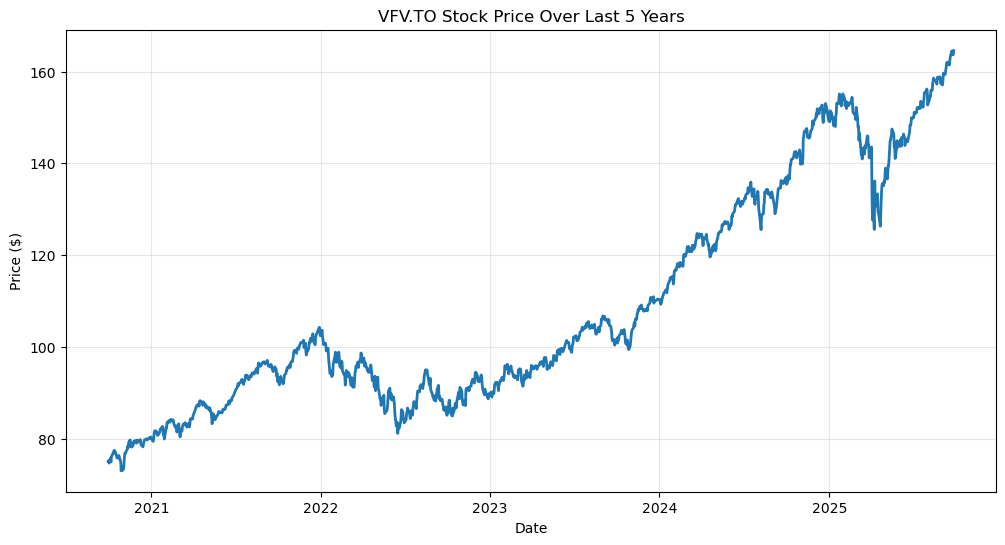

We'll be testing strategies on this 1253-day period


In [5]:
## Plotting Function 1: Plot Stock Price to See What We're Working With
plot_stock_data(data, symbol, years)

print(f"We'll be testing strategies on this {len(data)}-day period")


In [6]:
# Test the dip buying strategy

dip_results = dip_buying_strategy(data, daily_budget=daily_budget, dip_threshold=dip_threshold)

print("="*50)
print("DIP BUYING STRATEGY RESULTS:")
print("="*50)
print(f"Total money allocated: ${dip_results['total_invested']:,.2f}")
print(f"Final portfolio value: ${dip_results['final_value']:,.2f}")
print(f"Cash remaining: ${dip_results['cash_remaining']:.2f}")
print(f"Shares owned: {dip_results['shares']}")
print(f"Number of purchases: {len(dip_results['transactions'])}")

dip_profit = dip_results['final_value'] - dip_results['total_invested']
dip_profit_percent = (dip_profit / dip_results['total_invested']) * 100
print(f"Profit: ${dip_profit:,.2f} ({dip_profit_percent:.1f}%)")
print("_"*50)
print()

# Testing Dollar Cost Averaging
dollar_cost_averaging_results = dollar_cost_averaging_strategy(data, daily_budget=daily_budget, buy_frequency=7)
print("="*50)
print("Dollar Cost Averaging Results:")
print("="*50)

print(f"Total money allocated: ${dollar_cost_averaging_results['total_invested']:,.2f}")
print(f"Final portfolio value: ${dollar_cost_averaging_results['final_value']:,.2f}")
print(f"Cash remaining: ${dollar_cost_averaging_results['cash_remaining']:.2f}")
print(f"Shares owned: {dollar_cost_averaging_results['shares']}")
print(f"Number of purchases: {len(dollar_cost_averaging_results['transactions'])}")

dollar_cost_avg_profit = dollar_cost_averaging_results['final_value'] - dollar_cost_averaging_results['total_invested']
dollar_cost_avg_profit_percent = (dollar_cost_avg_profit / dollar_cost_averaging_results['total_invested']) * 100
print(f"Profit: ${dollar_cost_avg_profit:,.2f} ({dollar_cost_avg_profit_percent:.1f}%)")


Running Dip Buying Strategy:
- Daily budget: $72
- Dip threshold: 10.0%
- Starting peak price: $75.02

DIP BUYING STRATEGY RESULTS:
Total money allocated: $90,216.00
Final portfolio value: $129,878.98
Cash remaining: $8762.82
Shares owned: 736
Number of purchases: 5
Profit: $39,662.98 (44.0%)
__________________________________________________

Running Weekly Dollar cost averaging Strategy:
- Daily budget: $72
- Buying frequency: every 7 days

Dollar Cost Averaging Results:
Total money allocated: $90,216.00
Final portfolio value: $142,695.05
Cash remaining: $515.21
Shares owned: 864
Number of purchases: 178
Profit: $52,479.05 (58.2%)


In [7]:
# Comprare the two Strategies
print("="*70)
print("STRATEGY COMPARISON")
print("="*70)
# Keys serve as column headers, [] = rows values. 
comparison_data = {
    'Metric': ['Final Value', 'Return(%)', 'Purchases', 'Cash Remaining', 'Shares Owned'],
    f'Dip Buying ({dip_threshold*100:.1f}%)': [
        f'{dip_results['final_value']:,.2f}',
        f'{dip_profit_percent:.1f}%',
        len(dip_results['transactions']),
        f'{dip_results['cash_remaining']:,.2f}',
        dip_results['shares']
    ],
    'Dollar Cost Averaging': [
        f'{dollar_cost_averaging_results['final_value']:,.2f}',
        f'{dollar_cost_avg_profit_percent:.1f}%',
        len(dollar_cost_averaging_results['transactions']),
        f'{dollar_cost_averaging_results['cash_remaining']:,.2f}',
        dollar_cost_averaging_results['shares']
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)
# Determine the Winner
difference = dip_results['final_value'] - dollar_cost_averaging_results['final_value']
if difference > 0:
    print(f"\nDip Buying strategy outperformed Dollar Cost Averaging by ${difference:,.2f}")
elif difference < 0:
    print(f"\nDollar Cost Averaging outperformed Dip Buying strategy by ${-difference:,.2f}")
else:
    print("\nBoth strategies performed equally.")

print(f'\nKey Insights:')
print(f'- Dip Buying made {len(dip_results["transactions"])} purchases, while Dollar Cost Averaging made {len(dollar_cost_averaging_results["transactions"])} purchases.')
print(f'- Dip Buying strategy was more {"selective" if len(dip_results["transactions"]) < len(dollar_cost_averaging_results["transactions"]) else "frequent"} in its purchases.')


STRATEGY COMPARISON
           Metric Dip Buying (10.0%) Dollar Cost Averaging
0     Final Value         129,878.98            142,695.05
1       Return(%)              44.0%                 58.2%
2       Purchases                  5                   178
3  Cash Remaining           8,762.82                515.21
4    Shares Owned                736                   864

Dollar Cost Averaging outperformed Dip Buying strategy by $12,816.07

Key Insights:
- Dip Buying made 5 purchases, while Dollar Cost Averaging made 178 purchases.
- Dip Buying strategy was more selective in its purchases.


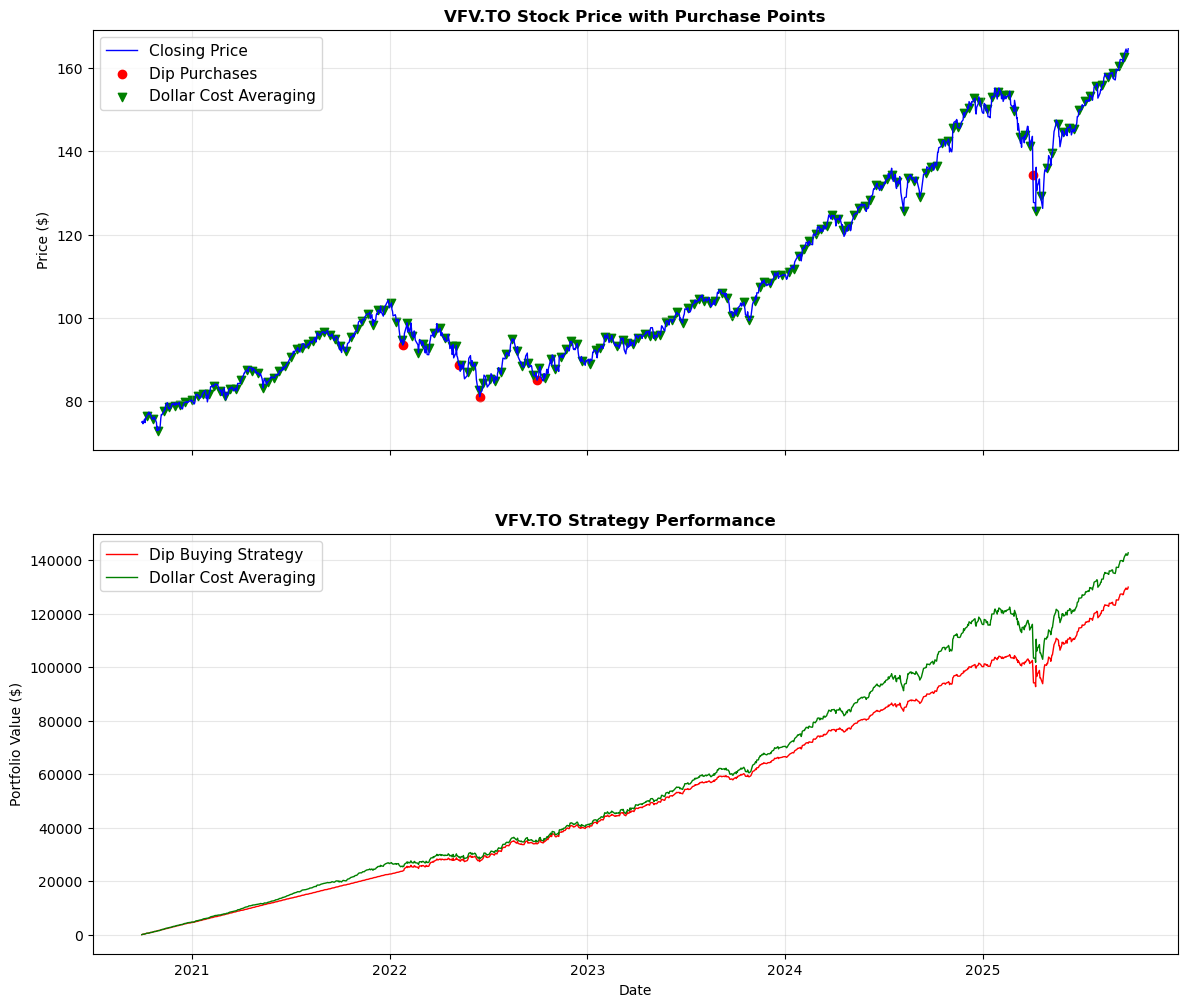

In [8]:
# Visualize Results
# Creates 2 subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot #1 - creates the pricing graph for the underlying stock
ax1.plot(data.index, data['Close'], color='blue', label='Closing Price', linewidth=1)

# create markers for purchases strategies
dip_dates = [tx['Date'] for tx in dip_results['transactions']]
dip_prices = [tx['Price'] for tx in dip_results['transactions']]
ax1.scatter(dip_dates, dip_prices, color='red', label='Dip Purchases', marker='o')  

dollar_cost_averaging_dates = [tx['Date'] for tx in dollar_cost_averaging_results['transactions']]
dollar_cost_averaging_prices = [tx['Price'] for tx in dollar_cost_averaging_results['transactions']]
ax1.scatter(dollar_cost_averaging_dates, dollar_cost_averaging_prices, color='green', label='Dollar Cost Averaging', marker='v')

ax1.set_title(f'{symbol} Stock Price with Purchase Points', fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot #2 - creates the performance graph for the strategies
ax2.plot(data.index, dip_results['daily_values'], color='red', label='Dip Buying Strategy', linewidth=1)
ax2.plot(data.index, dollar_cost_averaging_results['daily_values'], color='green', label='Dollar Cost Averaging', linewidth=1)

ax2.set_title(f'{symbol} Strategy Performance', fontweight='bold')
ax2.set_ylabel('Portfolio Value ($)')
ax2.set_xlabel('Date')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

In [9]:
# Testing on multiple Threshold parameters. 
print("\nTesting multiple dip thresholds:")
print('='*50)
dip_thresholds = [0.02, 0.05, 0.10, 0.15, 0.20]
result_summary = []
for threshold in dip_thresholds:
    result = dip_buying_strategy(data, daily_budget=daily_budget, dip_threshold=threshold)
    return_pct = (result['final_value'] - result['total_invested']) / result['total_invested']
    result_summary.append({
        'Dip Threshold': f"{threshold*100}%",
        'Final Value': f"{result['final_value']:,.2f}",
        'Return (%)': f"{return_pct*100:.2f}%",
        'Purchases': len(result['transactions'])
    })




Testing multiple dip thresholds:
Running Dip Buying Strategy:
- Daily budget: $72
- Dip threshold: 2.0%
- Starting peak price: $75.02

Running Dip Buying Strategy:
- Daily budget: $72
- Dip threshold: 5.0%
- Starting peak price: $75.02

Running Dip Buying Strategy:
- Daily budget: $72
- Dip threshold: 10.0%
- Starting peak price: $75.02

Running Dip Buying Strategy:
- Daily budget: $72
- Dip threshold: 15.0%
- Starting peak price: $75.02

Running Dip Buying Strategy:
- Daily budget: $72
- Dip threshold: 20.0%
- Starting peak price: $75.02



In [10]:
experiment_results = pd.DataFrame(result_summary)
print(experiment_results.to_string(index=False))
# Compare with Dollar Cost Average Baseline
print(f'Dollar Cost Average Baseline: {dollar_cost_avg_profit_percent:.1f}% Return')


Dip Threshold Final Value Return (%)  Purchases
         2.0%  141,063.45     56.36%         85
         5.0%  139,819.76     54.98%         17
        10.0%  129,878.98     43.96%          5
        15.0%  131,158.17     45.38%          2
        20.0%  120,585.21     33.66%          1
Dollar Cost Average Baseline: 58.2% Return


In [ ]:
quick_compare('SPY', start_date, end_date, daily_budget, dip_threshold)

Getting data for ['SPY'] from 2020-09-30 13:24:54.919547 to 2025-09-29 13:24:54.919547...


C:\Users\lippm\AppData\Local\Temp\ipykernel_23892\77600541.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Got 1254 days of data for 1 stocks
Running Dip Buying Strategy:
- Daily budget: $72
- Dip threshold: 10.0%
- Starting peak price: $312.20

Running Weekly Dollar cost averaging Strategy:
- Daily budget: $72
- Buying frequency: every 7 days

Results for SPY from 2020-09-30 13:24:54.919547 to 2025-09-29 13:24:54.919547:
- Dip Buying Strategy 10.0%: 37.29% return
- Dollar Cost Averaging Strategy: 50.82% return
Winner: Dollar Cost Averaging
